#STAT6289 Statistical Deep Learning
#Final Project: RNN for Image Captioning



Muzhe Guo, Lei Song

# Introduction
In this project, we will use both CNN and RNN to train a model to generate captions for given images.

To be specific, we will use pretrained MobileNet-v2 as CNN part to extract image features, then use RNN part to generate captions.

## Install starter code


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-nfmk89zs
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-nfmk89zs
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=79b0bf4d60803ad24f7904855abed3c24c9138d4610645f2620790ce8259d9d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-235tr2ir/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Run some setup code: import some useful packages and increase the default figure size.

In [2]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, \
                    tensor_to_image, decode_captions, attention_visualizer
import matplotlib.pyplot as plt
import time

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

We will use GPUs to accelerate our computation.

In [3]:
if torch.cuda.is_available:
  print('Good to go!')

Good to go!


# Data: Microsoft COCO
For this project, we will use the Microsoft COCO dataset. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions.

To make the process simple, we will use data which have been preprocessed. It contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words. 

There are a couple special tokens that have been added to the vocabulary. The special `<START>` token and `<END>` token are added to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. 

In [4]:
# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (112x112)
# "val_images" - resized validation images (112x112)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

!wget http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
data_dict = torch.load('coco.pt')

# print out all the keys and values from the data dictionary
for k, v in data_dict.items():
    if type(v) == torch.Tensor:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), v.keys())

num_train = data_dict['train_images'].size(0)
num_val = data_dict['val_images'].size(0)

# declare variables for special tokens
NULL_index = data_dict['vocab']['token_to_idx']['<NULL>']
START_index = data_dict['vocab']['token_to_idx']['<START>']
END_index = data_dict['vocab']['token_to_idx']['<END>']
UNK_index = data_dict['vocab']['token_to_idx']['<UNK>']

--2020-12-09 02:56:48--  http://web.eecs.umich.edu/~justincj/teaching/eecs498/coco.pt
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396583632 (378M)
Saving to: ‘coco.pt’

coco.pt             100%[===================>] 378.21M  54.3MB/s    in 7.7s    

2020-12-09 02:56:56 (48.9 MB/s) - ‘coco.pt’ saved [396583632/396583632]

train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])


## Look at the data
Look at examples from the dataset before working with it.

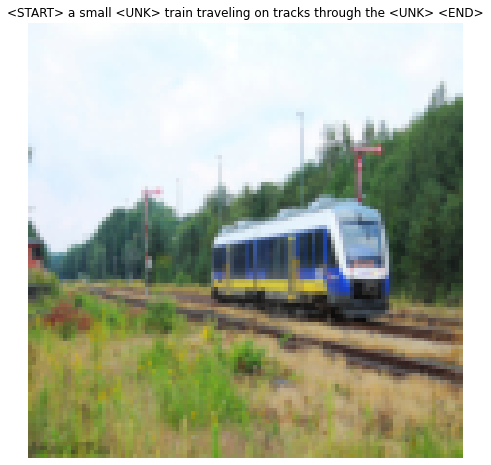

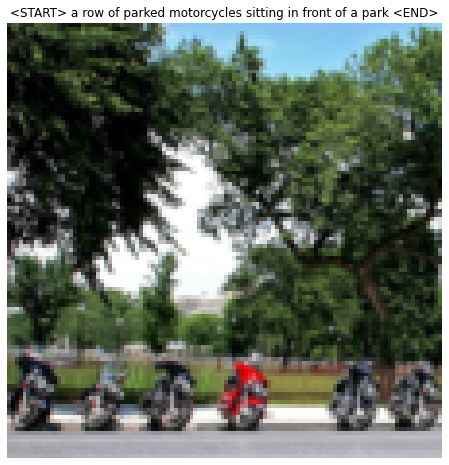

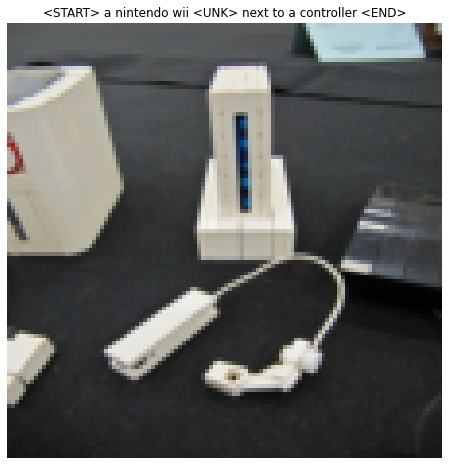

In [5]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 3

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  plt.title(caption_str)
  plt.show()

# RNN

## RNN: step forward
First implement the forward pass for a single timestep of a RNN.

In [6]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    next_h = torch.tanh(prev_h.mm(Wh) + x.mm(Wx) + b ) 
    cache = next_h, x, prev_h, Wx, Wh, b
    return next_h, cache

## RNN: forward
Now, combine these pieces to implement a RNN that processes an entire sequence of data. First implement the forward pass by making calls to the `rnn_step_forward` function that we defined earlier.

In [7]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None

    cache = []
    prev_h = h0 
    h = torch.zeros(x.shape[0], x.shape[1], h0.shape[1], **to_double_cuda)
    for t in range(x.shape[1]):
      prev_h, cache_t = rnn_step_forward(x[:,t,:], prev_h, Wx, Wh, b)
      h[:,t,:] = prev_h
      cache.append(cache_t)
 
    return h, cache

## RNN Module

Here we want to set up a module for RNN, where function `__init__` sets up weight and biases, and function `forward` call the `rnn_forward` function from before.

All the implementation will be with `autograd` and `nn.Module` going forward.

In [8]:
class RNN(nn.Module):
  """
  A single-layer RNN module.
  
  Arguments for initialization:
  - input_size: Input size, denoted as D before
  - hidden_size: Hidden size, denoted as H before
  """
  def __init__(self, input_size, hidden_size, device='cpu',
                dtype=torch.float32):
    """
    Initialize a RNN.
    Model parameters to initialize:
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases, of shape (H,)
    """
    super().__init__()
    
    # Register parameters
    self.Wx = Parameter(torch.randn(input_size, hidden_size,
                       device=device, dtype=dtype).div(math.sqrt(input_size)))
    self.Wh = Parameter(torch.randn(hidden_size, hidden_size,
                       device=device, dtype=dtype).div(math.sqrt(hidden_size)))
    self.b = Parameter(torch.zeros(hidden_size,
                       device=device, dtype=dtype))
    
  def forward(self, x, h0):
    """
    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D)
    - h0: Initial hidden state, of shape (N, H)

    Outputs:
    - hn: The hidden state output
    """
    hn, _ = rnn_forward(x, h0, self.Wx, self.Wh, self.b)
    return hn
  
  def step_forward(self, x, prev_h):
    """
    Inputs:
    - x: Input data for one time step, of shape (N, D)
    - prev_h: The previous hidden state, of shape (N, H)

    Outputs:
    - next_h: The next hidden state, of shape (N, H)
    """
    next_h, _ = rnn_step_forward(x, prev_h, self.Wx, self.Wh, self.b)
    return next_h

# CNN: MobileNet v2 

## Image Feature Extraction
Here, we use MobileNet v2 for image feature extraction.

In [9]:
# !pip install torchsummary
class FeatureExtractor(object):
  """
  Image feature extraction with MobileNet.
  """
  def __init__(self, pooling=False, verbose=False,
               device='cpu', dtype=torch.float32):

    from torchvision import transforms, models
    from torchsummary import summary
    self.preprocess = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    self.device, self.dtype = device, dtype
    self.mobilenet = models.mobilenet_v2(pretrained=True).to(device)
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier
    
    # average pooling
    if pooling:
      self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(4, 4)) # input: N x 1280 x 4 x 4
    
    self.mobilenet.eval()
    if verbose:
      summary(self.mobilenet, (3, 112, 112))
  
  def extract_mobilenet_feature(self, img, verbose=False):
    """
    Inputs:
    - img: Batch of resized images, of shape N x 3 x 112 x 112

    Outputs:
    - feat: Image feature, of shape N x 1280 (pooled) or N x 1280 x 4 x 4
    """
    num_img = img.shape[0]
    
    img_prepro = []
    for i in range(num_img):
      img_prepro.append(self.preprocess(img[i].type(self.dtype).div(255.)))
    img_prepro = torch.stack(img_prepro).to(self.device)
    
    with torch.no_grad():
      feat = []
      process_batch = 500
      for b in range(math.ceil(num_img/process_batch)):
        feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                                ).squeeze(-1).squeeze(-1)) # forward and squeeze
      feat = torch.cat(feat)
      
      # add l2 normalization
      F.normalize(feat, p=2, dim=1)
    
    if verbose:
      print('Output feature shape: ', feat.shape)
    
    return feat

Now, let's see what's inside MobileNet v2. Assume we have a 3x112x112 image input. We pass argument `pooling=True` to the model so the CNN activation is spatially-pooled from `1280x4x4` to `1280`.

In [10]:
model = FeatureExtractor(pooling=True, verbose=True, device='cuda')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
             ReLU6-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]             288
       BatchNorm2d-5           [-1, 32, 56, 56]              64
             ReLU6-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]             512
       BatchNorm2d-8           [-1, 16, 56, 56]              32
  InvertedResidual-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           1,536
      BatchNorm2d-11           [-1, 96, 56, 56]             192
            ReLU6-12           [-1, 96, 56, 56]               0
           Conv2d-13           [-1, 96, 28, 28]             864
      BatchNorm2d-14           [-1, 96

# Word embedding
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Implement the module `WordEmbedding` to convert words (represented by integers) into vectors.

In [11]:
class WordEmbedding(nn.Module):
  """
  Simplified version of torch.nn.Embedding.

  We operate on minibatches of size N where
  each sequence has length T. We assume a vocabulary of V words, assigning each
  word to a vector of dimension D.

  Inputs:
  - x: Integer array of shape (N, T) giving indices of words. Each element idx
    of x muxt be in the range 0 <= idx < V.

  Returns a tuple of:
  - out: Array of shape (N, T, D) giving word vectors for all input words.
  """
  def __init__(self, vocab_size, embed_size,
               device='cpu', dtype=torch.float32):
      super().__init__()
      
      # Register parameters
      self.W_embed = Parameter(torch.randn(vocab_size, embed_size,
                         device=device, dtype=dtype).div(math.sqrt(vocab_size)))
      
  def forward(self, x):
      out = None
      out = self.W_embed[x] 
      return out

# Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

Since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `ignore_index` that tells it which index in caption should be ignored when computing the loss.

In [12]:
def temporal_softmax_loss(x, y, ignore_index=NULL_index):
    """
    A temporal version of softmax loss for use in RNNs. We assume that we are
    making predictions over a vocabulary of size V for each timestep of a
    timeseries of length T, over a minibatch of size N. The input x gives scores
    for all vocabulary elements at all timesteps, and y gives the indices of the
    ground-truth element at each timestep. We use a cross-entropy loss at each
    timestep, *summing* the loss over all timesteps and *averaging* across the
    minibatch.

    Inputs:
    - x: Input scores, of shape (N, T, V)
    - y: Ground-truth indices, of shape (N, T) where each element is in the range
         0 <= y[i, t] < V

    Returns a tuple of:
    - loss: Scalar giving loss
    """
    loss = None
    
    N, T = x.shape[0], x.shape[1]  
    loss = F.cross_entropy(x.transpose(1,2), y, ignore_index = ignore_index, reduction='sum')* 1. / N
                                  
    return loss

# Captioning Module
Now we are wrapping everything into the captioning module. Implement the `__init__` function for initialization and the `captioning_forward` for the forward pass.

In [13]:
class CaptioningRNN(nn.Module):
    """
    A CaptioningRNN produces captions from images using a recurrent
    neural network.

    The RNN receives input vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, uses word vectors
    of dimension W, and operates on minibatches of size N.

    Note that we don't use any regularization for the CaptioningRNN.
    """
    def __init__(self, word_to_idx, input_dim=512, wordvec_dim=128,
                 hidden_dim=128, cell_type='rnn', device='cpu', dtype=torch.float32):
        """
        Inputs:
        - word_to_idx: A dictionary giving the vocabulary. It contains V entries,
          and maps each string to a unique integer in the range [0, V).
        - input_dim: Dimension D of input image feature vectors.
        - wordvec_dim: Dimension W of word vectors.
        - hidden_dim: Dimension H for the hidden state of the RNN.
        - cell_type: What type of RNN to use: 'rnn'.
        - dtype: datatype to use; use float32 for training and float64 for
          numeric gradient checking.
        """
        super().__init__()
 
        self.cell_type = cell_type
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}

        vocab_size = len(word_to_idx)

        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)
        self.dtype = dtype
        self.device = device
        self.hidden_dim =hidden_dim
        ##########################################################################
        # Initialize the image captioning module.                                #
        #                                                                        #
        # Use nn.Linear for both                                                 #
        # i) output projection (from RNN hidden state to vocab probability) and  #
        # ii) feature projection (from CNN pooled feature to h0)                 #
        #                                                                        #
        # In FeatureExtractor, set pooling=True to get the pooled CNN feature    #
        # and pooling=False to get the CNN activation map.                       #
        ##########################################################################

        #Initialize CNN -> hidden state(h0) projection parameters: 
        self.W_proj = Parameter(torch.randn(input_dim, hidden_dim, device=device, dtype=dtype).div(math.sqrt(input_dim)))
        self.b_proj = Parameter(torch.zeros(hidden_dim, device=device, dtype=dtype))
     
        #Initialize word embedding matrix   
        self.W_embed =  Parameter( torch.randn(vocab_size, wordvec_dim, device=device, dtype=dtype).div(math.sqrt(vocab_size)))

        #Initialize parameters for the RNN 
        self.Wx = Parameter(torch.randn(wordvec_dim,  hidden_dim, device=device, dtype=dtype).div(math.sqrt(wordvec_dim)))
        self.Wh = Parameter(torch.randn(hidden_dim,   hidden_dim, device=device, dtype=dtype).div(math.sqrt(hidden_dim)))
        self.b = Parameter(torch.zeros(hidden_dim, device=device, dtype=dtype))
  
        #Initialize RNN hidden state -> vocab probability
        self.W_vocab = Parameter( torch.randn(hidden_dim, vocab_size, device=device, dtype=dtype).div(math.sqrt(hidden_dim)))
        self.b_vocab = Parameter( torch.zeros(vocab_size, device=device, dtype=dtype))

    
    def forward(self):
      #leave blank, add later 
      raise NotImplementedError
    
    def sample(self):
      #leave blank, add later 
      raise NotImplementedError


### Forward part
Implement the forward function.

In [14]:
    def captioning_forward(self, images, captions):
        """
        Compute training-time loss for the RNN. We input images and
        ground-truth captions for those images, and use an RNN to compute
        loss. The backward part will be done by torch.autograd.

        Inputs:
        - images: Input images, of shape (N, 3, 112, 112)
        - captions: Ground-truth captions; an integer array of shape (N, T + 1) where
          each element is in the range 0 <= y[i, t] < V

        Outputs:
        - loss: A scalar loss
        """
        # Cut captions into two pieces: captions_in has everything but the last word
        # and will be input to the RNN; captions_out has everything but the first
        # word and this is what we will expect the RNN to generate. These are offset
        # by one relative to each other because the RNN should produce word (t+1)
        # after receiving word t. The first element of captions_in will be the START
        # token, and the first element of captions_out will be the first word.
        
        captions = captions.to(self.device) 
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]
        loss = 0.0

        # In the forward pass, do the following:                                   
        # (1) Use an affine transformation to project the image feature to         
        #     the initial hidden state $h0$ of shape (N, H)                        
        # (2) Use a word embedding layer to transform the words in captions_in     
        #     from indices to vectors, giving an array of shape (N, T, W).         
        # (3) Use RNN to process the sequence of input word vectors and produce    
        #     hidden state vectors for all timesteps, producing an array of        
        #     shape (N, T, H)                                                      
        # (4) Use a (temporal) affine transformation to compute scores over the    
        #     vocabulary at every timestep using the hidden states, giving an      
        #     array of shape (N, T, V).                                            
        # (5) Use (temporal) softmax to compute loss using captions_out, ignoring  
        #     the points where the output word is <NULL>.                          
        
        #(1) h0
        N = images.shape[0]
        H = self.hidden_dim # hidden dimension 
        FeatureExtractorModel = FeatureExtractor(pooling=True, verbose=False, device=self.device, dtype=self.dtype)
        images_feature = FeatureExtractorModel.extract_mobilenet_feature(images) 
        h0 = images_feature.mm(self.W_proj)+self.b_proj    #N,H

        #(2)
        word_vectors =  self.W_embed[captions_in]          #N,T,W
        
        #(3)
        hidden_state, _ = rnn_forward(word_vectors, h0, self.Wx, self.Wh, self.b)  #N,T,H 
        hidden_state = hidden_state.to(self.dtype)  
        N,T,H = hidden_state.shape

        #(4)
        voc_scores = hidden_state.reshape(N*T, H).mm(self.W_vocab)+self.b_vocab   # N*T, V
        voc_scores = voc_scores.reshape(N,T,-1)                                 # N, T, V   

        #(5)
        loss = temporal_softmax_loss(voc_scores, captions_out)

        return loss

    CaptioningRNN.forward = captioning_forward

### Inference part


In [15]:
    def sample_caption(self, images, max_length=15):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state is computed by applying an affine
        transform to the image features, and the initial word is the <START>
        token.

        Inputs:
        - images: Input images, of shape (N, 3, 112, 112)
        - max_length: Maximum length T of generated captions

        Returns:
        - captions: Array of shape (N, max_length) giving sampled captions,
          where each element is an integer in the range [0, V). The first element
          of captions should be the first sampled word, not the <START> token.
        """

        N = images.shape[0]
        H = self.hidden_dim  
        captions = self._null * images.new(N, max_length).fill_(1).long()

        # Implement test-time sampling for the model.                             
        # do the following each timestep                                          
        # (1) Embed the previous word using the learned word embeddings           
        # (2) Make an RNN step using the previous hidden state and the embedded   
        #     current word to get the next hidden state.                          
        # (3) Apply the learned affine transformation to the next hidden state to 
        #     get scores for all words in the vocabulary                          
        # (4) Select the word with the highest score as the next word, writing it 
        #     (the word index) to the appropriate slot in the captions variable   
        
        
        #feature Extraction
        FeatureExtractorModel = FeatureExtractor(pooling=True, verbose=False, device=self.device, dtype=self.dtype)
        images_feature = FeatureExtractorModel.extract_mobilenet_feature(images)
        prev_h = images_feature.mm(self.W_proj)+self.b_proj  # using image features as h0
        prev_c = torch.zeros_like(prev_h) 
        captions[:, 0] = self._start
       
        for t in range(0, max_length):
          word_vectors = self.W_embed[captions[:, t]]  # N, W 
          next_h, _ =  rnn_step_forward(word_vectors, prev_h, self.Wx, self.Wh, self.b)  #N, H 
          prev_h = next_h

          voc_scores = next_h.mm(self.W_vocab)+self.b_vocab  #N, V 
          captions[:, t] = voc_scores.argmax(dim=1) 
          if t != max_length-1:     #initial next captions
            captions[:, t+1] = voc_scores.argmax(dim=1) 

        return captions

    CaptioningRNN.sample = sample_caption

In [16]:
def CaptioningTrain(rnn_model, image_data, caption_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnn_model.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(image_data.shape[0] // batch_size)
  loss_history = []
  rnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      images, captions = image_data[j*batch_size:(j+1)*batch_size], \
                           caption_data[j*batch_size:(j+1)*batch_size]

      loss = rnn_model(images, captions)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()

## Overfit small data
Overfits a small sample of 50 training examples.

learning rate is:  0.001
(Epoch 0 / 80) loss: 75.8224 time per epoch: 0.2s
(Epoch 1 / 80) loss: 67.0012 time per epoch: 0.2s
(Epoch 2 / 80) loss: 60.4483 time per epoch: 0.2s
(Epoch 3 / 80) loss: 54.3054 time per epoch: 0.2s
(Epoch 4 / 80) loss: 49.3854 time per epoch: 0.2s
(Epoch 5 / 80) loss: 45.9541 time per epoch: 0.2s
(Epoch 6 / 80) loss: 43.3490 time per epoch: 0.2s
(Epoch 7 / 80) loss: 41.2224 time per epoch: 0.2s
(Epoch 8 / 80) loss: 39.3455 time per epoch: 0.2s
(Epoch 9 / 80) loss: 37.4133 time per epoch: 0.2s
(Epoch 10 / 80) loss: 35.7491 time per epoch: 0.2s
(Epoch 11 / 80) loss: 34.0604 time per epoch: 0.2s
(Epoch 12 / 80) loss: 32.5906 time per epoch: 0.2s
(Epoch 13 / 80) loss: 31.2827 time per epoch: 0.2s
(Epoch 14 / 80) loss: 30.3981 time per epoch: 0.2s
(Epoch 15 / 80) loss: 28.8555 time per epoch: 0.2s
(Epoch 16 / 80) loss: 26.9717 time per epoch: 0.2s
(Epoch 17 / 80) loss: 26.1337 time per epoch: 0.2s
(Epoch 18 / 80) loss: 24.3719 time per epoch: 0.2s
(Epoch 19 / 80) 

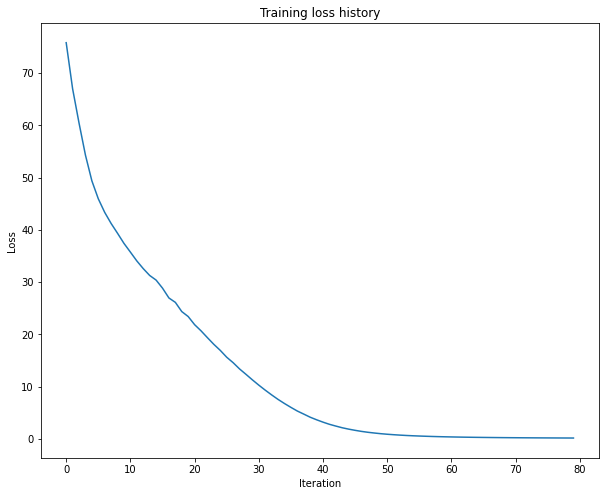

In [17]:
fix_random_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_float_cuda).long()
small_image_data = data_dict['train_images'][sample_idx]
small_caption_data = data_dict['train_captions'][sample_idx]

# optimization arguments
num_epochs = 80
batch_size = 50
  
# create the image captioning model
model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, #1280 hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Train the net


learning rate is:  0.001
(Epoch 0 / 60) loss: 46.4822 time per epoch: 10.3s
(Epoch 1 / 60) loss: 40.0917 time per epoch: 10.1s
(Epoch 2 / 60) loss: 36.5446 time per epoch: 10.1s
(Epoch 3 / 60) loss: 33.3740 time per epoch: 10.1s
(Epoch 4 / 60) loss: 31.1686 time per epoch: 10.1s
(Epoch 5 / 60) loss: 29.0961 time per epoch: 10.1s
(Epoch 6 / 60) loss: 27.1545 time per epoch: 9.9s
(Epoch 7 / 60) loss: 25.7007 time per epoch: 10.1s
(Epoch 8 / 60) loss: 24.0871 time per epoch: 10.0s
(Epoch 9 / 60) loss: 22.6587 time per epoch: 9.9s
(Epoch 10 / 60) loss: 21.1179 time per epoch: 9.9s
(Epoch 11 / 60) loss: 19.6349 time per epoch: 10.0s
(Epoch 12 / 60) loss: 18.6430 time per epoch: 9.9s
(Epoch 13 / 60) loss: 17.4681 time per epoch: 9.9s
(Epoch 14 / 60) loss: 16.2807 time per epoch: 9.9s
(Epoch 15 / 60) loss: 15.1104 time per epoch: 10.0s
(Epoch 16 / 60) loss: 13.7733 time per epoch: 9.9s
(Epoch 17 / 60) loss: 13.1476 time per epoch: 9.9s
(Epoch 18 / 60) loss: 12.5405 time per epoch: 9.8s
(Epoch

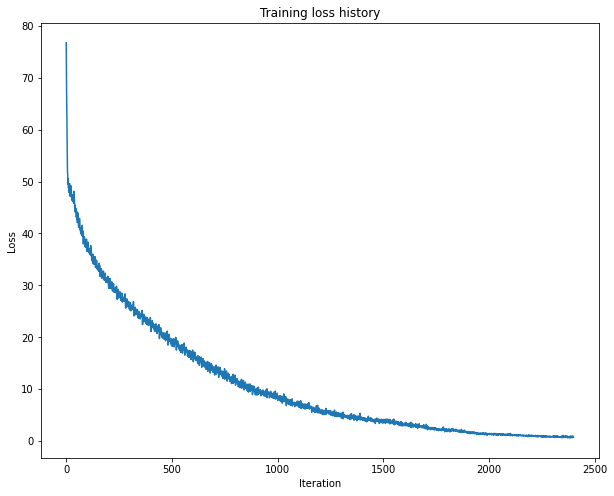

In [18]:
fix_random_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'][sample_idx]
small_caption_data = data_dict['train_captions'][sample_idx]

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280 , #1280 # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  CaptioningTrain(rnn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Test-time sampling
The samples on training data is very good; the samples on validation data will probably make less sense.

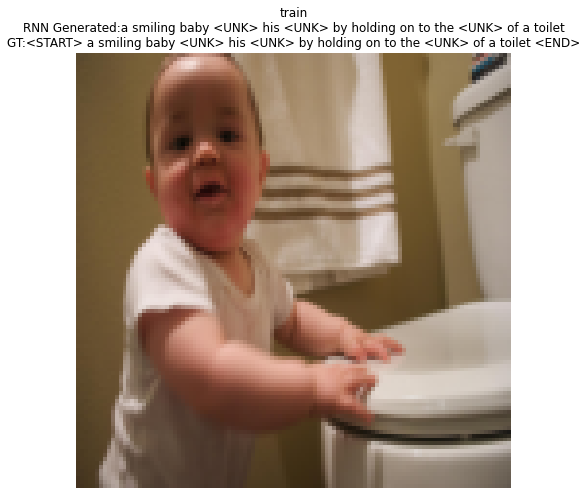

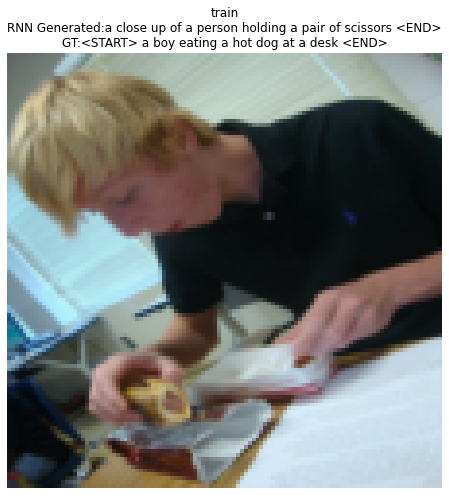

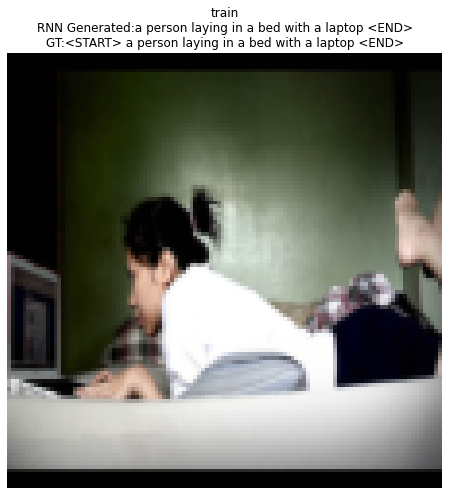

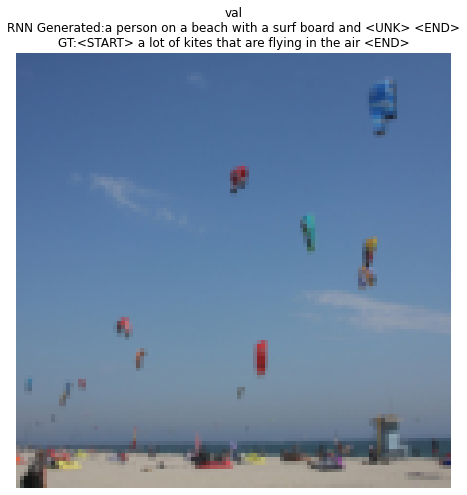

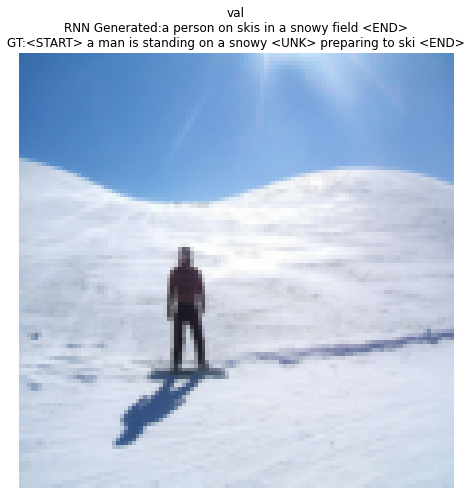

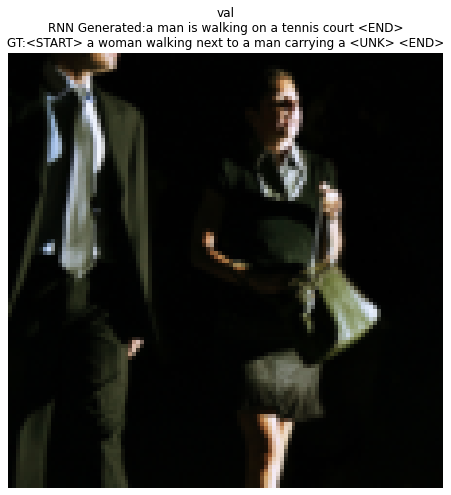

In [19]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by our model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx].to('cuda')
  sample_captions = data_dict[split+'_captions'][sample_idx].to('cuda')

  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  rnn_model.eval()
  generated_captions = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('%s\nRNN Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()